## Objective- To estimate the revenue figure of uber in a year in NY and it's growth and also aimed to expose all the interesting insights that can be derived from a detailed analysis of the dataset.

In [9]:
#Import relevant libraries and define settings for plotting.
%matplotlib inline
import sys
print(sys.version)

import numpy as np
#print 'Numpy version:', np.__version__

import pandas as pd
#print 'Pandas version:', pd.__version__

import matplotlib as mpl
import matplotlib.pyplot as plt
#print 'Matplotlib version:', mpl.__version__

import seaborn as sns
#print 'Seaborn version:', sns.__version__

import datetime
import time

sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)

#Avoid display of scientific notation and show precision of 4 decimals:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [10]:
df_uber = pd.read_csv('uber_nyc_data.csv')

This uber dataset contains data about Uber’s ridership between September 2014 and August 2015. This dataset contains ~31 million rows and columns of origin, destination, pickup date and time, trip distance, and duration.

The combination of trip distance and duration allows for estimating Uber’s revenue for each trip in NYC. In another hand, the pickup and drop-off locations were anonymized and grouped as taxi zones instead of geographic coordinates. This is a better attempt to preserve data privacy, but it precludes the positioning of such locations on a map.

In [11]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   origin_taz       object 
 2   destination_taz  object 
 3   pickup_datetime  object 
 4   trip_distance    float64
 5   trip_duration    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [12]:

df_uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.2500,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.1700,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.0200,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.4600,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.3100,0:26:17


In [13]:
len(df_uber.id.unique())

30925738

## Check for missing or possibly erroneous data

In [14]:
len(df_uber[df_uber.duplicated() == True])

0

No duplicate entries are present in dataset.

In [15]:
df_uber.isnull().sum() 

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

Show total null values per column. Use .sum() to just show which columns.

Note: ~1.3 million destination entries (4%) are null (missing) and 38 rows are missing from trip distance and duration columns(means there are possibility that 38 rows are missing from trip duration and distance from same rows so we will investigate it later.)

In [16]:
arr1 = df_uber.origin_taz.unique() 
arr1

array(['7C', '7B', '11', '3B', '2A', '5B', '10', '2B', '9', '6B', '15',
       '4C', '5A', '8', '14', '4A', '7A', '1', '16', '3A', '2C', '6A',
       '12', '13', '3C', '4B', '5C', '17'], dtype=object)

28 unique origin codes or pick up locations.

In [17]:
arr2 = df_uber.destination_taz.unique() 
arr2

array(['6A', '15', '2A', '4A', '10', '4C', '7A', '3C', '5B', '14', '8',
       nan, '7C', '12', '2C', '1', '6B', '5C', '9', '3A', '2B', '11',
       '7B', '5A', '13', '4B', '18', '16', '3B', '17'], dtype=object)

:30 unique destination codes i.e drop locations same as origin except for nan and 18

In [18]:
set(arr2) - set(arr1) 

{'18', nan}

Here maybe code 18 represents EWR airport?(EWR airport or Newark Airport is a airport near New York City (~25 km/15 miles) and many of its passengers are flying to or from NYC, that's why it's considered one of NYC's 3 regional airports (along with LaGuardia and Kennedy.)

In [19]:
df_uber[df_uber.destination_taz.isnull()].head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15,252596,6B,NaN,2014-09-01 17:00:00,11.6700,0:23:45
32,252613,9,NaN,2014-09-01 16:00:00,80.6900,1:59:37
63,252644,9,NaN,2014-09-01 18:00:00,23.0700,1:03:37
141,252722,9,NaN,2014-09-01 10:00:00,21.7300,0:41:12
148,252729,4B,NaN,2014-09-01 10:00:00,4.6200,0:14:55


Checked some of the data with missing destination. One idea to fill missing values would be predict destination based on the other features.

In [20]:
df38 = df_uber[df_uber.trip_duration.isnull() & df_uber.trip_distance.isnull()]
#df38
df38.head(38)

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,39535,2A,11,2015-04-25 12:00:00,NaN,NaN
15245057,1009076,2A,2A,2015-04-26 01:00:00,NaN,NaN
16519652,15028665,2A,7C,2015-04-29 21:00:00,NaN,NaN
17148253,22250173,2A,2A,2015-04-12 02:00:00,NaN,NaN
17297563,23716998,2C,11,2015-04-25 13:00:00,NaN,NaN
17478943,25656087,7A,4C,2015-04-29 08:00:00,NaN,NaN
17980063,544754,10,15,2015-05-09 02:00:00,NaN,NaN
18385948,4428619,6B,2A,2015-05-20 19:00:00,NaN,NaN
18420794,4897670,9,7A,2015-05-12 06:00:00,NaN,NaN
18432788,4909664,2C,5C,2015-05-20 09:00:00,NaN,NaN


On Investigation we that all 38 records with values missing for trip distance and duration from the same rows, but origin and distination is not missing which means trip done ad revenue generated through it.

In [21]:
#All cases for which trip_duration is null match the cases for which trip_distance is also null:
len(df_uber[(df_uber.trip_duration.isnull() == False) & (df_uber.trip_distance.isnull())])

0

## Parse the pickup_datetime column to datetime type and create related features.

In [22]:
#None of the pickup time data offer minutes or seconds precision
len(df_uber[df_uber.pickup_datetime.apply(lambda x: x[-5:] == '00:00') == False])

0

In [23]:
def dateParser(s):
    return datetime.datetime(int(s[0:4]), int(s[5:7]), int(s[8:10]), int(s[11:13]))

we had seen in df_uber.info analysis that pick_datetime is string data type so we use date_parser method to convert it into date time object.
date_parser : Function to use for converting a sequence of string columns to an array of datetime instances.

date_parser Function that takes a string in the format yyyy-mm-dd hh:mm:ss, and returns the same as a datetime object. 

In [24]:
df_uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.2500,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.1700,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.0200,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.4600,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.3100,0:26:17


In [25]:
#Apply parser to data
t0 = time.time()
df_uber['pu_date_hour'] = df_uber.pickup_datetime.apply(dateParser)
time.time() - t0

112.22754955291748

we applied the date parser method and converted datetime object featured in pu_date_hour column( pu_date_hour= pick up time and date)

In [26]:
df_uber.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour
0,252581,7C,6A,2014-09-01 09:00:00,4.2500,0:15:11,2014-09-01 09:00:00
1,252582,7B,15,2014-09-01 18:00:00,10.1700,0:34:05,2014-09-01 18:00:00
2,252583,11,2A,2014-09-01 17:00:00,4.0200,0:17:06,2014-09-01 17:00:00
3,252584,3B,4A,2014-09-01 13:00:00,1.4600,0:06:32,2014-09-01 13:00:00
4,252585,2A,10,2014-09-01 14:00:00,8.3100,0:26:17,2014-09-01 14:00:00


In [27]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   pickup_datetime  object        
 4   trip_distance    float64       
 5   trip_duration    object        
 6   pu_date_hour     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.6+ GB


Here we can drop pickup_datetime column since we have pu_date_hour column.

In [28]:
#Drop repeated column
df_uber = df_uber.drop('pickup_datetime', axis=1)

In [29]:
#Data encompasses exactly 365 days from Sept 1st, 2014 to Sep 1st, 2015.
beginning = df_uber.pu_date_hour.min()
end = df_uber.pu_date_hour.max()
print(beginning, end, end - beginning)

2014-09-01 00:00:00 2015-09-01 00:00:00 365 days 00:00:00


In [30]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00


## Get the federal holidays for the period (useful for analyzing data later)

In [31]:
#Get all federal holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

#if return_name is True, then name is series value and date is the series index, otherwise date is series value. 
holidays = USFederalHolidayCalendar().holidays(beginning, end, return_name = True) 
holidays

2014-09-01                              Labor Day
2014-10-13                           Columbus Day
2014-11-11                           Veterans Day
2014-11-27                       Thanksgiving Day
2014-12-25                          Christmas Day
2015-01-01                         New Year's Day
2015-01-19    Birthday of Martin Luther King, Jr.
2015-02-16                  Washington's Birthday
2015-05-25                           Memorial Day
2015-07-03                       Independence Day
dtype: object

We get the list of all holidays occurs during the same time period of 365 days and we analyse the no. of uber rides the a day before holidays and a day after holiday and on that day as well.

In [32]:
#Extract the weekday for each holiday
holidays.index.map(lambda x: x.strftime('%a'))

Index(['Mon', 'Mon', 'Tue', 'Thu', 'Thu', 'Thu', 'Mon', 'Mon', 'Mon', 'Fri'], dtype='object')

In [33]:
#For completeness, let's add the day before and after the holidays (better: add day after if Thursday)
holidays_all = pd.concat([holidays, "Day After " + holidays.shift(1, 'D'), "Day Before " + holidays.shift(-1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head(10)

2014-08-31           Day Before Labor Day
2014-09-01                      Labor Day
2014-09-02            Day After Labor Day
2014-10-12        Day Before Columbus Day
2014-10-13                   Columbus Day
2014-10-14         Day After Columbus Day
2014-11-10        Day Before Veterans Day
2014-11-11                   Veterans Day
2014-11-12         Day After Veterans Day
2014-11-26    Day Before Thanksgiving Day
dtype: object

### Feature Engineering
Feature engineering is the science (and art) of extracting more information from existing data. You are not adding any new data here, but you are actually making the data you already have more useful.

For example, let’s say you are trying to predict foot fall in a shopping mall based on dates. If you try and use the dates directly, you may not be able to extract meaningful insights from the data. This is because the foot fall is less affected by the day of the month than it is by the day of the week. Now this information about day of week is implicit in your data. You need to bring it out to make your model better.

## Create other date and time features.

In [34]:
#Create a column with the date, without the time. This will be useful later.
t0 = time.time()
df_uber['pu_date'] = pd.Series(map(lambda x: x.astype('datetime64[D]'), df_uber['pu_date_hour'].values))
time.time() - t0

186.47311687469482

In [35]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01


In [36]:
#Get month and year from pick up timestamp
df_uber['year'] = df_uber['pu_date_hour'].dt.year
df_uber['month'] = df_uber['pu_date_hour'].dt.month

In [37]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9


In [38]:
#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day #.apply(lambda x: x.day) = 105 seconds vs < 2 seconds with dt
time.time() - t0

1.9884700775146484

In [39]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1


In [40]:
#Get trip pick up hour from timestamp
t0 = time.time()
df_uber['hour'] = df_uber['pu_date_hour'].dt.hour #< 2 seconds vs 101 seconds using apply lambda
time.time() - t0

1.7761931419372559

In [41]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14


In [42]:
#Get trip pick up weekday from timestamp
t0 = time.time()
df_uber['weekday'] = df_uber['pu_date_hour'].dt.dayofweek
time.time() - t0

2.5818090438842773

In [43]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0


In [44]:
df_uber.weekday.value_counts() #Monday = 0, Sunday = 6

weekday
5    5142832
4    4805002
3    4625511
6    4331195
2    4301537
1    4010434
0    3709227
Name: count, dtype: int64

In [45]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0


In [46]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   trip_distance    float64       
 4   trip_duration    object        
 5   pu_date_hour     datetime64[ns]
 6   pu_date          datetime64[ns]
 7   year             int32         
 8   month            int32         
 9   day              int32         
 10  hour             int32         
 11  weekday          int32         
dtypes: datetime64[ns](2), float64(1), int32(5), int64(1), object(3)
memory usage: 2.2+ GB


Year, Month,day,hour and week day features has been created in order to perform better analysis with respect to that.

## Transform trip duration data.

In [47]:
uniq_dur = df_uber[df_uber.trip_duration.isnull() == False].trip_duration.unique() #19393

In [48]:
print(len(uniq_dur))

19393


In [49]:
#Among unique duration strings, find how many represent >= 10h of duration:
long_duration = [] #>= 10 hours or 600 minutes
for item in uniq_dur:
    if len(item) != 7:
        long_duration.append(item)

#long_duration
print(len(long_duration))

386


In [50]:
#Check for the most unusual strings for trip duration: some erroneous entries need to be addressed
for item in long_duration:
    if len(item) > 8:
        print(item)

172032:14:50
172032:39:03
136:25:12
172032:17:45
172032:19:27
119:53:35
120:49:05


In [51]:
def duration_to_minutes(s):
    """
    Function that takes a string with the hh:mm:ss format and
    returns the integer equivalent of the total time in minutes, 
    or zero for missing values in a Pandas dataframe.
    """
    if pd.isnull(s):
        val = 0 #note: this fills with 0 the 38 instances with null (missing) values
    else:
        hms = s.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val

In [52]:
#Transform the trip duration string into trip duration in minutes:
t0 = time.time()
df_uber['duration_min'] = df_uber.trip_duration.apply(duration_to_minutes) 
time.time() - t0

79.04627323150635

In [53]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.1833
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.0833
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.1000
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.5333
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.2833


In this section we have transformed the trip duration from hms format to minutes so that we are able to calculate the Revenue and avoid those erroneous data from calculation which is not possible in practical life, we will se it's application in later sectio

## Replace missing values with mean distance and duration for respective origin-destination.

Which are the methods to treat missing values ? Following 4 methods generally we used to treat the missing values from dataset:

 [Deletion-It is of two types:]List Wise Deletion and Pair Wise Deletion. Deletion methods are used when the nature of missing data is “Missing completely at random” else non random missing values can bias the model output.

[Mean/ Mode/ Median Imputation:]It consists of replacing the missing data for a given attribute by the mean or median (quantitative attribute) or mode (qualitative attribute) of all known values of that variable. and most often we use this method to fill the missing values. It can be of two types:-

[Generalized Imputation:] In this case, we calculate the mean or median for all non missing values of that variable then replace missing value with mean or median.
Similar case Imputation: In this case, we calculate the mean or median or mode based on some similar categorical rows like we impute heights of athletes based on gender since female atheles are generally shorter than males.And In this below section We used similar case imputation.
when we use Mean or median imputation? Advantages and Disadvantages of mean/median/mode imputation?
Ans-If distribution is normal distribution then we use mean and if distribution is skewed then we use median. Advantages- Simple and easy to use,gives better result for <5% data missing.Disadvantages-Distribution shape changes(variance shrinked),extra outlier can be added,covariance/correlation changes.
Prediction Model: Here, we create a predictive model to estimate values that will substitute the missing data.

[KNN Imputation:]In this method of imputation, the missing values of an attribute are imputed using the given number of attributes that are most similar to the attribute whose values are missing. 

In [54]:
#Get the mean distance and duration for each origin-destination pair
df_DistDur = df_uber.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'duration_min']].mean()

In [55]:
df_DistDur.head()

trip_distance  duration_min
origin_taz destination_taz                             
1          1                       1.4219       10.5655
           10                      3.6508       17.9776
           11                      5.0937       22.4899
           12                      8.8878       29.1024
           13                     11.5831       32.1568

In [56]:
#Replace 38 missing values with the average distance and duration for the respective origin-destination pair
for i in df38.index:
    orig = df_uber.loc[i, 'origin_taz']
    dest = df_uber.loc[i, 'destination_taz']
    df_uber.loc[i, 'trip_distance'] = df_DistDur.loc[orig, dest].trip_distance
    df_uber.loc[i, 'duration_min'] = df_DistDur.loc[orig, dest].duration_min

In [57]:
df_uber.isnull().sum()# here trip_duration still showing 38 null values because missing values replaced in duration min 

id                       0
origin_taz               0
destination_taz    1273023
trip_distance            0
trip_duration           38
pu_date_hour             0
pu_date                  0
year                     0
month                    0
day                      0
hour                     0
weekday                  0
duration_min             0
dtype: int64

## Calculate average speed for each trip.

In [58]:
#Calculate average trip speed (mph) to help in understanding outliers (like trips with duration >10 h):
df_uber['trip_mph_avg'] = df_uber.trip_distance/(df_uber.duration_min/60.0)

In [59]:
#Check that trip_distance and duration_min have been replaced, and trip speed has been calculated:
df_uber.iloc[df38.index, :].head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg
15155317,39535,2A,11,3.9368,NaN,2015-04-25 12:00:00,2015-04-25,2015,4,25,12,5,19.7321,11.9708
15245057,1009076,2A,2A,1.3588,NaN,2015-04-26 01:00:00,2015-04-26,2015,4,26,1,6,10.9195,7.4660
16519652,15028665,2A,7C,9.0394,NaN,2015-04-29 21:00:00,2015-04-29,2015,4,29,21,2,30.2041,17.9566
17148253,22250173,2A,2A,1.3588,NaN,2015-04-12 02:00:00,2015-04-12,2015,4,12,2,6,10.9195,7.4660
17297563,23716998,2C,11,4.8331,NaN,2015-04-25 13:00:00,2015-04-25,2015,4,25,13,5,24.3851,11.8918


In [60]:
#Drop redundant trip_duration columns
df_uber = df_uber.drop('trip_duration', axis=1)
df_uber = df_uber.drop('pu_date_hour', axis=1)

## Calculate Estimated Revenue per Trip.

In [61]:
#Source: http://uberestimate.com/prices/New-York-City/ for Uber X
base_fare = 2.55
per_minute = 0.35
per_mile = 1.75
min_fare = 8

In [62]:
#Using eval() is even more efficient for large datasets than resorting to Numpy! 
#Local variables must be followed by @. Only for arithmetic, cannot use if statement, for example.
df_uber['est_revenue'] = df_uber.eval('@base_fare + duration_min * @per_minute + trip_distance * @per_mile')
df_uber.loc[df_uber.est_revenue < 8, 'est_revenue'] = min_fare

In [63]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917


## Queries for Checking Data Consistency.

What is an Outlier?

Outlier is an observation that appers for away and diverse from overall pattern. Outlier tend to make our data skewed and reduces

## A closer look of the anomalous cases of trip duration.

In [64]:
#Check for very long duration entries, and effect on revenue numbers:

#>=100h:
print(len(df_uber[(df_uber.duration_min >= 6000)])) #7



#>16h and <100h : 116 entries
df_uber[(df_uber.duration_min > 960) & (df_uber.duration_min < 6000)].est_revenue.sum() #$78,070 total revenue

7


np.float64(78069.74916666666)

Greater than 100h: 7 entries (erroneous): system error? fraud? Total revenue is relevant: $14,459,978 (2.4% of total) probable system error: distance < 10 miles

The effect on revenue is relevant only for the trips higher than 100h of duration, which are most likely a result of some system error (as seen above), or perhaps fraud, therefore these 7 entries will be excluded from the dataset for analysis. However, assuming that driving more than 16h (960 minutes) non-stop per day represents unreliable data,these additional 116 cases will also be excluded from analysis. These 123 data points warrant more in-depth internal investigation to bring light to what may have caused them.

->Were the trips with distance and duration equal to zero actually cancelled (didn't happen)?

->There is at least one case almost daily. The 24866 cases represent a revenue of 198,928,basedon
8 minimum fare.

In [65]:
 print(len(df_uber[(df_uber.duration_min == 0) & (df_uber.trip_distance == 0)])) #24866

24866


->Note that origin and destination are the same, except for 910 trips: did these trips in fact occur?

->There is generally a fee associated with trip cancellation, so unless these trips represent a system error or fraud,there was no loss of the minimum fare revenue.

In [66]:
df_uber[(df_uber.duration_min == 0) & (df_uber.trip_distance == 0) & (df_uber.origin_taz != df_uber.destination_taz)].\
head()#910

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
21726,274307,4B,8,0.0000,2014-09-29,2014,9,29,17,0,0.0000,NaN,8.0000
21847,274428,4C,2A,0.0000,2014-09-29,2014,9,29,17,0,0.0000,NaN,8.0000
21909,274490,5C,6A,0.0000,2014-09-29,2014,9,29,19,0,0.0000,NaN,8.0000
22179,274760,11,4A,0.0000,2014-09-29,2014,9,29,17,0,0.0000,NaN,8.0000
22359,274940,3C,1,0.0000,2014-09-30,2014,9,30,14,1,0.0000,NaN,8.0000


Check cases with distance equal to zero but duration greater than zero

In [67]:
print(len(df_uber[(df_uber.duration_min > 0) & (df_uber.trip_distance == 0)])) #85515

85515


The median duration for trips with zero distance is 10 seconds (mean= 2.4 minutes), so most of these 85,515 cases possibly represent trips that were cancelled right after they were registered.3873 trips of the 85,515 cases show pick up and drop off in different taxi zones (median duration: 10 seconds, mean: 4.5 minutes).

->Let's check the small dataset (277) out of the 3873 cases with duration > 5 minutes, but distance equal to zero:Maybe these cases represent some error with registering the distance traveled?

In [68]:
df_uber[(df_uber.duration_min >= 5) & (df_uber.trip_distance == 0) &(df_uber.origin_taz != df_uber.destination_taz)]\
.head(10)

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
882890,18153735,1,2A,0.0000,2014-09-28,2014,9,28,1,6,7.1167,0.0000,8.0000
3223424,29754237,4C,6A,0.0000,2014-10-05,2014,10,5,20,6,7.5167,0.0000,8.0000
18154210,2023861,1,4C,0.0000,2015-05-28,2015,5,28,12,3,27.2000,0.0000,12.0700
18829282,8785823,4B,8,0.0000,2015-05-26,2015,5,26,16,1,38.7833,0.0000,16.1242
19414939,14586763,4C,5C,0.0000,2015-05-28,2015,5,28,18,3,11.0167,0.0000,8.0000
20674992,27149481,4C,1,0.0000,2015-05-28,2015,5,28,11,3,32.8500,0.0000,14.0475
21376632,3045165,1,6B,0.0000,2015-06-28,2015,6,28,23,6,32.8167,0.0000,14.0358
21472913,4006319,15,4A,0.0000,2015-06-26,2015,6,26,10,4,55.7333,0.0000,22.0567
21517547,4482860,1,5C,0.0000,2015-06-23,2015,6,23,13,1,22.3500,0.0000,10.3725
21727436,6421520,6B,NaN,0.0000,2015-06-26,2015,6,26,9,4,78.2333,0.0000,29.9317


In [69]:
print(len(df_uber[df_uber.trip_mph_avg <= 3])) #262,666 cases

262666


In [70]:
df_uber[(df_uber.trip_mph_avg <= 3) & (df_uber.trip_distance <= 2)].head(10) #246,225, or ~94% of all trips with < 3mph

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
82,252663,14,14,0.0200,2014-09-01,2014,9,1,11,0,1.3333,0.9000,8.0000
120,252701,2A,2A,1.5100,2014-09-01,2014,9,1,20,0,33.8833,2.6739,17.0517
271,252852,8,8,0.0000,2014-09-01,2014,9,1,16,0,0.5000,0.0000,8.0000
542,253123,4C,4C,0.0500,2014-09-02,2014,9,2,17,1,1.1000,2.7273,8.0000
554,253135,2A,2A,0.0000,2014-09-02,2014,9,2,9,1,2.6833,0.0000,8.0000
605,253186,2A,2A,0.0500,2014-09-02,2014,9,2,20,1,1.4500,2.0690,8.0000
839,253420,2A,2A,0.4700,2014-09-02,2014,9,2,13,1,10.5833,2.6646,8.0000
896,253477,5C,6B,0.9900,2014-09-02,2014,9,2,17,1,22.1833,2.6777,12.0467
945,253526,14,14,0.0400,2014-09-02,2014,9,2,2,1,1.4000,1.7143,8.0000
1260,253841,4A,4A,0.0600,2014-09-02,2014,9,2,20,1,1.3500,2.6667,8.0000


0.8% of cases from the entire dataset have calculated speed < 3mph : really bad traffic cases, interrupted trips, or fraud? We will assume they're mostly really bad traffic cases or interrupted trips for this analysis.

Among the trips with very slow speed (< 3 mph), the most suspicious cases are perhaps those that show very long duration. Let's say that 1.5h would have been enough, in most situations, to get outside of some traffic gridlock, then part of these cases should be investigated more in depth, especially because they represent a significant share of the revenue ($850K).

In [71]:
df_uber[(df_uber.trip_mph_avg <= 3) & (df_uber.duration_min > 90) & (df_uber.duration_min <= 960)].head(10)#8393 cases

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
539,253120,5B,10,8.3400,2014-09-02,2014,9,2,11,1,173.3667,2.8864,77.8233
7798,260379,6A,6A,6.0100,2014-09-11,2014,9,11,12,3,128.1500,2.8139,57.9200
14734,267315,6B,5C,9.0800,2014-09-19,2014,9,19,13,4,196.2500,2.7761,87.1275
14996,267577,4C,6A,5.4800,2014-09-20,2014,9,20,15,5,110.7000,2.9702,50.8850
17131,269712,2A,NaN,4.8800,2014-09-21,2014,9,21,20,6,100.4667,2.9144,46.2533
21955,274536,6B,6B,2.9700,2014-09-29,2014,9,29,12,0,91.0833,1.9565,39.6267
22567,275148,4C,4C,1.3700,2014-09-30,2014,9,30,14,1,106.4833,0.7720,42.2167
24080,736706,6B,3A,6.0500,2014-09-02,2014,9,2,16,1,243.2167,1.4925,98.2633
27977,740603,4C,2B,4.9900,2014-09-07,2014,9,7,18,6,129.9500,2.3040,56.7650
29077,741703,4A,5A,7.9400,2014-09-08,2014,9,8,15,0,208.4500,2.2854,89.4025


Due to the lack of specific domain knowledge about the system that has generated this data, and unavailability of more detailed trip information, these cases will be disregarded as suspicious in this analysis. It's possible,

len(df_uber[(df_uber.month==8)&(df_uber.year==2015)])(1)-2.4% to total revenue estimated by considering trip duration greater than 100 hour would be sysytem error and should not be considered for revenue estimation and even the trip duration greater than 16 hour also not reliable that is also excluded for revenue estimation.

(2)-24866 cases are cancelled trips that should not be included in revenue estimation.

(3)-Average speed less than 3km(i.e. less than walking speed) could be error,fraud or really bad traffic.

(1)-2.4% to total revenue estimated by considering trip duration greater than 100 hour would be sysytem error and should not be considered for revenue estimation and even the trip duration greater than 16 hour also not reliable that is also excluded for revenue estimation.

(2)-24866 cases are cancelled trips that should not be included in revenue estimation.

(3)-Average speed less than 3km(i.e. less than walking speed) could be error,fraud or really bad traffic.

# Filter Dataset
->A few data points represent the zeroth hour of Sep, 2015, extending the time period beyond exactly 365 days:

In [72]:
len(df_uber[df_uber.pu_date == datetime.date(2015, 9, 1)]) 

0

In [73]:
#->Create dataframe to be used for visualization with exactly 365 days of data, and max trip duration of 16h:

df_viz = df_uber[(df_uber.pu_date != datetime.date(2015, 9, 1)) & (df_uber.duration_min <= 960)].copy() #1975 cases

In [74]:
print(len(df_viz))

30925615


In [75]:
#Descriptive statistics for numerical features:
df_viz[['duration_min', 'trip_distance', 'trip_mph_avg', 'est_revenue']].describe()

,duration_min,trip_distance,trip_mph_avg,est_revenue
count,30925615.0000,30925615.0000,30900749.0000,30925615.0000
mean,20.9921,5.1997,13.5073,19.2419
std,16.0844,6.1308,11.7568,15.0808
min,0.0000,0.0000,0.0000,8.0000
25%,10.8500,1.6900,8.4100,9.5733
50%,17.2333,3.0900,11.4489,14.3508
75%,26.6833,6.2300,16.2669,23.0308
max,959.3000,568.5700,22548.0000,1225.8583


In [76]:
#Required by Plotly:
import matplotlib.mlab as mlab
#import plotly.plotly as py

In [116]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   trip_distance    float64       
 4   pu_date          datetime64[ns]
 5   year             int32         
 6   month            int32         
 7   day              int32         
 8   hour             int32         
 9   weekday          int32         
 10  duration_min     float64       
 11  trip_mph_avg     float64       
 12  est_revenue      float64       
dtypes: datetime64[ns](1), float64(4), int32(5), int64(1), object(2)
memory usage: 2.4+ GB


In [77]:
from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) #Create image box
#from matplotlib._png import read_png #Load png file
from matplotlib.patches import Ellipse #Draw ellipse

In [78]:
#Create functions to format tick numbers
def thousands_comma(x, pos):
    """
    Args are the value and tick position. 
    Returns number with thousands comma and no decimals.
    """
    return '{:,.0f}'.format(x) #this is the new syntax for formatting

In [79]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)

In [80]:
def millions_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with one decimal, and M in lieu of 6 zeros.
    """
    return '{:.1f}{}'.format(x * 1e-6, 'M')

In [81]:
def millions_currency(x, pos):
    """
    Args are the value and tick position. 
    Returns number of millions with a $ sign, M in lieu of 6 zeros, and no decimals.
    """
    return '{}{:.0f}{}'.format('$', x * 1e-6, 'M')

In [82]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
        return None

Above defined functions is to represent large numbers in thousands(K) and millions(M) format.
# Visualizing the demand: number of Uber trips per day.

In [114]:
#Create a plotting dataframe with counts (number of trips) grouped by day:
byDate = df_viz.groupby('pu_date')['id'].count() #365 complete entries
 

KeyError: 'pu_date'

In [113]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hour     1000 non-null   int32
 1   weekday  1000 non-null   int32
 2   month    1000 non-null   int32
dtypes: int32(3)
memory usage: 11.8 KB


In [84]:
byDate['2014-10-28': '2014-11-05'] #an uptick in rides on 11/1, the day before the NYC marathon!

pu_date
2014-10-28     52084
2014-10-29     61082
2014-10-30     66369
2014-10-31     71787
2014-11-01    104450
2014-11-02     57289
2014-11-03     50491
2014-11-04     52395
2014-11-05     61518
Name: id, dtype: int64

In [85]:
byDate['2015-06-01': '2015-08-31'].mean()

np.float64(107630.82608695653)

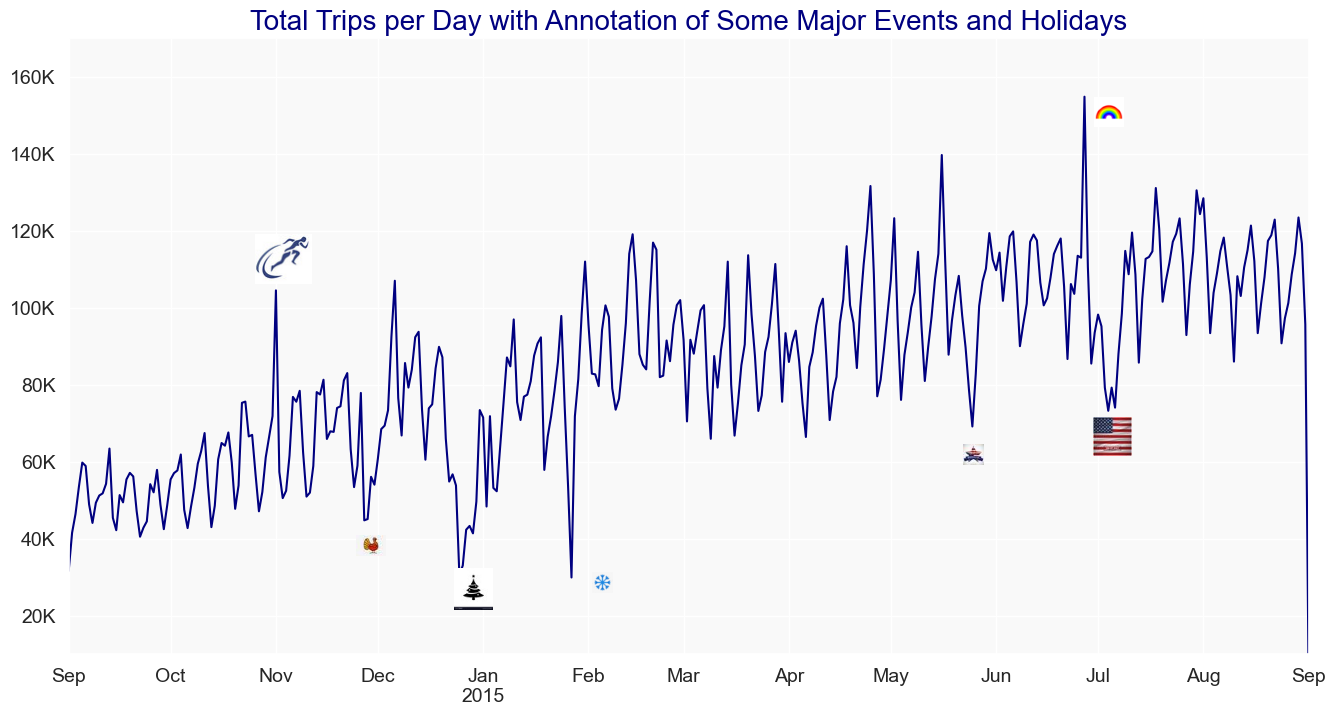

In [86]:
#Create a plot with the total number of trips per day, highlighting some changepoints associated with major holidays 
#and other weather and touristic/cultural events.
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import FuncFormatter
from matplotlib.image import imread

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

formatter = FuncFormatter(thousands_format)
ax.yaxis.set_major_formatter(formatter)
ax.set_facecolor('#F9F9F9') #make background color a lighter gray to better contrast with the icon's images.

plt.title('Total Trips per Day with Annotation of Some Major Events and Holidays', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')


#Add icon to indicate snowstorm on the plot:
#NYC's mayor ordered the city under curfew, and public transportation system was shut down late on 1/26/15.
img1 = imread('Snow.png')
imagebox = OffsetImage(img1, zoom=0.6)
xy = ['2015-01-27', 25000] # (len(byDate[:'2015-01-27'])-1, byDate['2015-01-27'])

ab = AnnotationBbox(imagebox, xy, 
                    xybox=(22., 10.), #position from xy to lower left corner of box
                    xycoords='data', #will use data coordinates for x and y
                    boxcoords='offset points', #same idea as textcoords, in points from lower left corner
                    pad=0.1, frameon=False) #padding around the image
ax.add_artist(ab)


#Add icon to indicate Thanksgiving on the plot:
img2 = imread('thanksgiving.jpg')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-11-27', 40000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)
#Add icon to indicate Christmas on the plot:
img2 = imread('ctree.jpg')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-12-25', 25000] 
ab = AnnotationBbox(imagebox, xy, xybox=(10., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Memorial Day Holiday on the plot:
img3 = imread('mday.jpg')
imagebox = OffsetImage(img3, zoom=0.6) 
xy = ['2015-05-25', 60000] 
ab = AnnotationBbox(imagebox, xy, xybox=(1., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Pride Week on the plot:
#According to The Wall Street Journal, the Pride Parade was attended by 1.6 million people in 2015.
img4 = imread('rainbow.png')
imagebox = OffsetImage(img4, zoom=0.6) 
xy = ['2015-06-27', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Independence Day Holiday on the plot:
img5 = imread('iday.jpg')
imagebox = OffsetImage(img5, zoom=0.6) 
xy = ['2015-07-03', 70000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -10.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate NYC Marathon event on the plot:
img5 = imread('marathon.jpg')
imagebox = OffsetImage(img5, zoom=0.7) 
xy = ['2014-11-01', 110000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., 7.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

plt.show()

# The effect of major events on the number of trips.

negative impacts are related to Thanksgiving, Christmas, Memorial Day, and Independence Day.

A lingering (two consecutive days) drop in activity is seen for all these holidays but Memorial Day. It turns out that the July 4th holiday was observed on Friday in 2015.

an apparently odd and very significant drop in the number of trips is shown on January 27th. This was a result of a curfew imposed by the NYC’s mayor in preparation for a blizzard.

The plot also highlights which events have positively impacted the number of trips that year, with the International Marathon and the Gay Pride Week standing out as the strongest contributors.

# The effect of time on demand for Uber rides: distribution per hour, weekday, and month.

In [87]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\823521683.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(weekday_labels)
C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\823521683.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(month_labels)


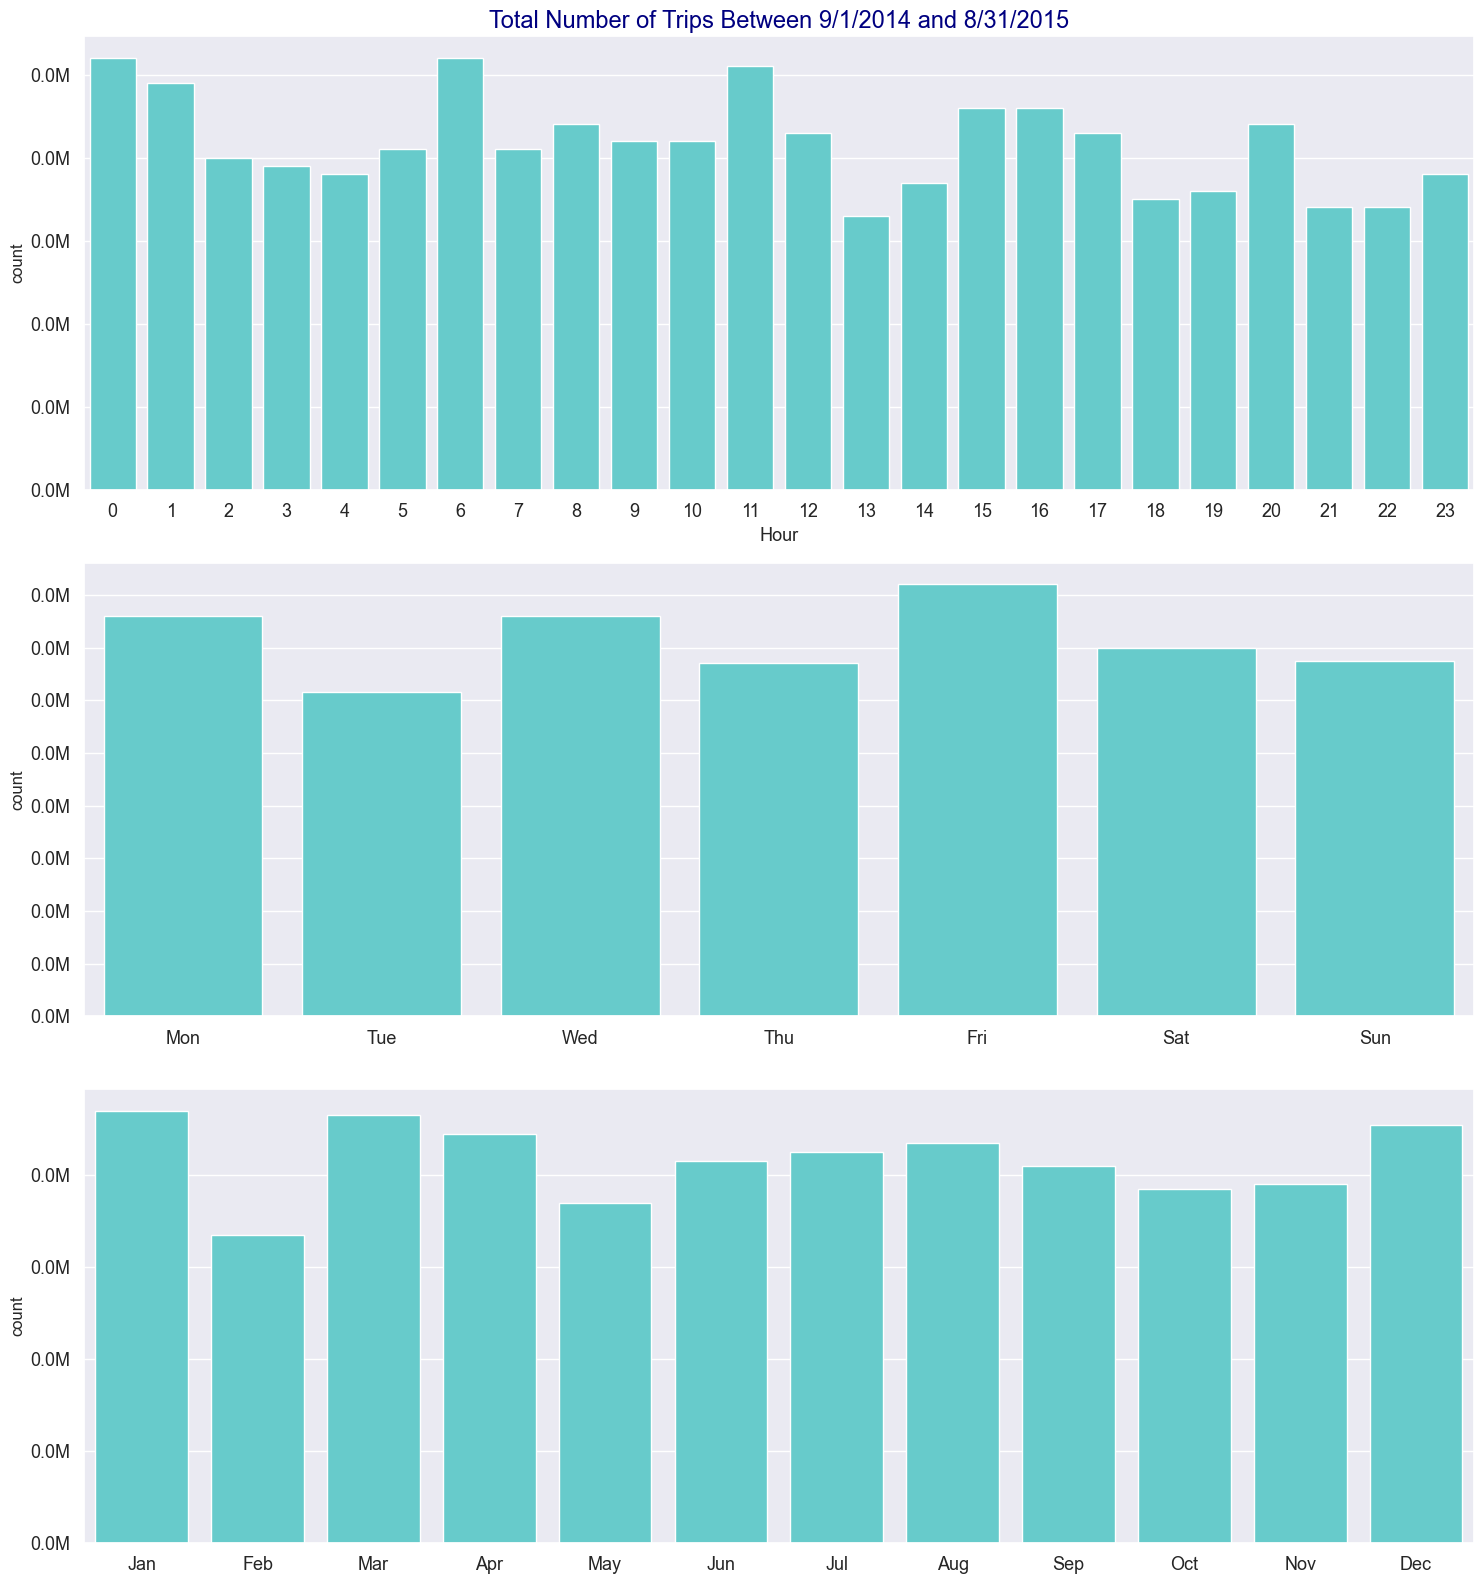

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Assuming you have defined millions_format function
# Example data or your data loading logic
# df_viz = ...

fig = plt.figure(figsize=(15, 16))
formatter = FuncFormatter(millions_format)

plt.subplot(3, 1, 1)
ax1 = sns.countplot(data=df_viz, x='hour', order=range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips Between 9/1/2014 and 8/31/2015', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3, 1, 2)
ax2 = sns.countplot(data=df_viz, x='weekday', order=range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3, 1, 3)
ax3 = sns.countplot(data=df_viz, x='month')
ax3.set_xticklabels(month_labels)
ax3.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

# Estimated Monthly Base Revenue: how much was the NYC market worth in the period?
For the first time, it’s possible to estimate Uber’s revenue in NYC with more granularity due to the availability of each trip’s duration and distance in the dataset. However, the revenue figures are described as “base revenue“, because other critical information is missing.

Uber offers different types of services with distinct prices, namely Uber X, Uber XL, Uber Black, Uber SUV, and Uber Pool. Except for the latter, all other services carry a higher fare than Uber X. Moreover, Uber practices “price surging”, which affects the revenue positively.

Here we chose to use Uber X published fares to calculate the revenue as this is probably the most popular product. Therefore, the base revenue is a conservative estimate of the actual revenue.

In [111]:
df_viz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   hour     1000 non-null   int32
 1   weekday  1000 non-null   int32
 2   month    1000 non-null   int32
dtypes: int32(3)
memory usage: 11.8 KB


In [117]:
#Create dataframe with grouped revenue data:
#Create dataframe with grouped revenue data:
byDateRev = df_uber.groupby('month')['est_revenue'].sum()

In [118]:
#Estimate Uber's gross margin for the entire 1 year period based on 25% share of the base revenue.
sumRev = byDateRev.sum()
print("Base Revenue: ${:,.0f}M".format(sumRev * 1e-6), "Uber's Base Gross Margin: ${:,.0f}".format(sumRev * .25))

Base Revenue: $610M Uber's Base Gross Margin: $152,401,131


In [122]:
#Estimated base gross margin based on information that average UberX fare in Sep 2014 was $27 (but it has dropped):
len(df_uber) * 27 * .25

208748731.5

In [121]:
byDateRev.head()

month
1   41457151.3925
2   47253261.4617
3   52154385.1658
4   54096764.4595
5   61544275.2684
Name: est_revenue, dtype: float64

In [123]:
sumRev= byDateRev.sum()
sumRev

np.float64(609604525.2932718)

C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\1015594855.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_labels)


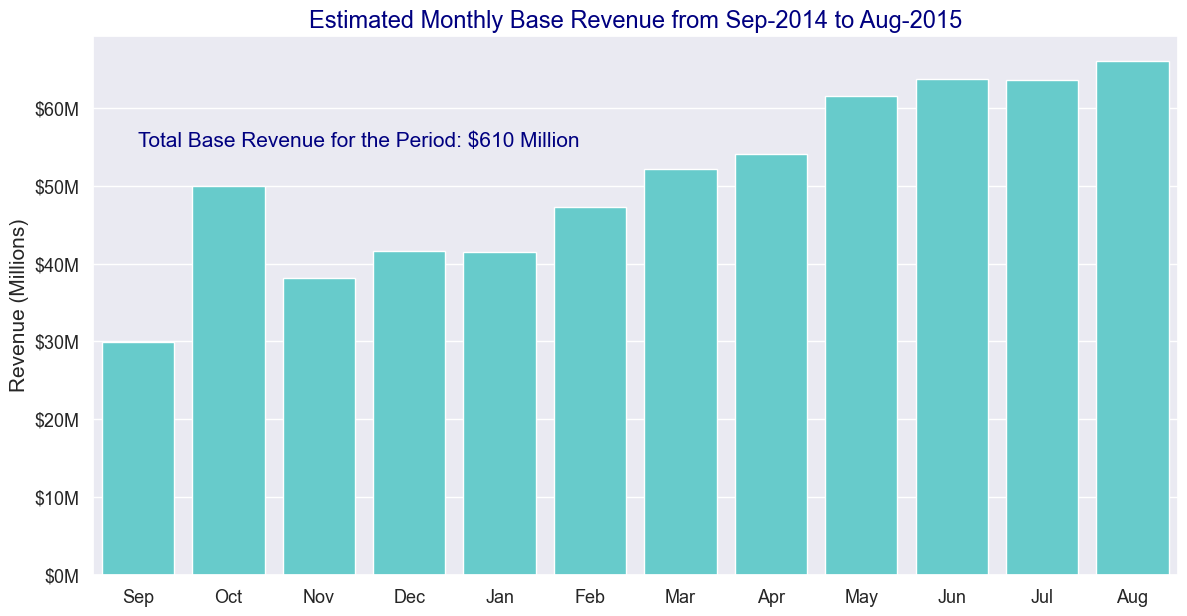

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Define your millions_currency function
def millions_currency(x, pos):
    return "${:,.0f}M".format(x * 1e-6)

# Example data or your data loading logic


months_seq = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']  # Calculate total revenue

plt.figure(figsize=(14, 7))
formatter = FuncFormatter(millions_currency)

ax = sns.barplot(x=byDateRev.index, y= byDateRev.values, order = months_seq)
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

font = {'color': 'navy', 'size': 15}
plt.text(0, 55000000, 'Total Base Revenue for the Period: ${:,.0f} Million'.format(sumRev * 1e-6),
         fontdict=font)
plt.xlabel('')
plt.ylabel('Revenue (Millions)', fontsize=15)
plt.tick_params(labelsize=13)
plt.title('Estimated Monthly Base Revenue from Sep-2014 to Aug-2015', fontsize=17, color='navy')

plt.show()

It’s important to note that from the gross estimated revenue, Uber’s share is about 25% of the total. Therefore, we can conservatively estimate that Uber’s gross margin in NYC from September 2014 to August 2015 was in the order of 150 million dollars. The estimated gross margin, considering instead the 27 average fare previously mentioned, was of the order of 210 million dollars.
Total revenue of Uber in 1 Year is 595M and Gross margin of 149M.
In bar plot we observed that revenue per month generally increases month by month in that period except the month of january and june, this may happened because of 2 Federal holiday's in month of january and summer vacation started from july.

In [126]:
df_uber.est_revenue.mean()

np.float64(19.711882875463534)

Mean fare from revenue estimate for the period: $19.71 (assumes all trips are Uber X)
# Month over Month Base Revenue Growth: how fast has Uber grown in the period?

In [127]:
#Create dictionary with calculated month over month revenue percentage growth:
dict_growth = {}
for i in range(len(months_seq)):
    mo = months_seq[i]
    rev = byDateRev[mo]
    if mo == 9:
        growth_pct = 0
    elif mo == 1:
        growth_pct = ((rev/byDateRev[12]) - 1) * 100
    else:
        growth_pct = ((rev/byDateRev[mo - 1]) - 1) * 100
    print(month_labels[i], 'Revenue =', '${:,.0f}'.format(rev), 'Growth % = ', '{:.1f}%'.format(growth_pct))
    dict_growth[month_labels[i]] = growth_pct

Sep Revenue = $29,974,920 Growth % =  0.0%
Oct Revenue = $49,992,021 Growth % =  66.8%
Nov Revenue = $38,175,182 Growth % =  -23.6%
Dec Revenue = $41,667,257 Growth % =  9.1%
Jan Revenue = $41,457,151 Growth % =  -0.5%
Feb Revenue = $47,253,261 Growth % =  14.0%
Mar Revenue = $52,154,385 Growth % =  10.4%
Apr Revenue = $54,096,764 Growth % =  3.7%
May Revenue = $61,544,275 Growth % =  13.8%
Jun Revenue = $63,680,229 Growth % =  3.5%
Jul Revenue = $63,622,431 Growth % =  -0.1%
Aug Revenue = $65,986,648 Growth % =  3.7%


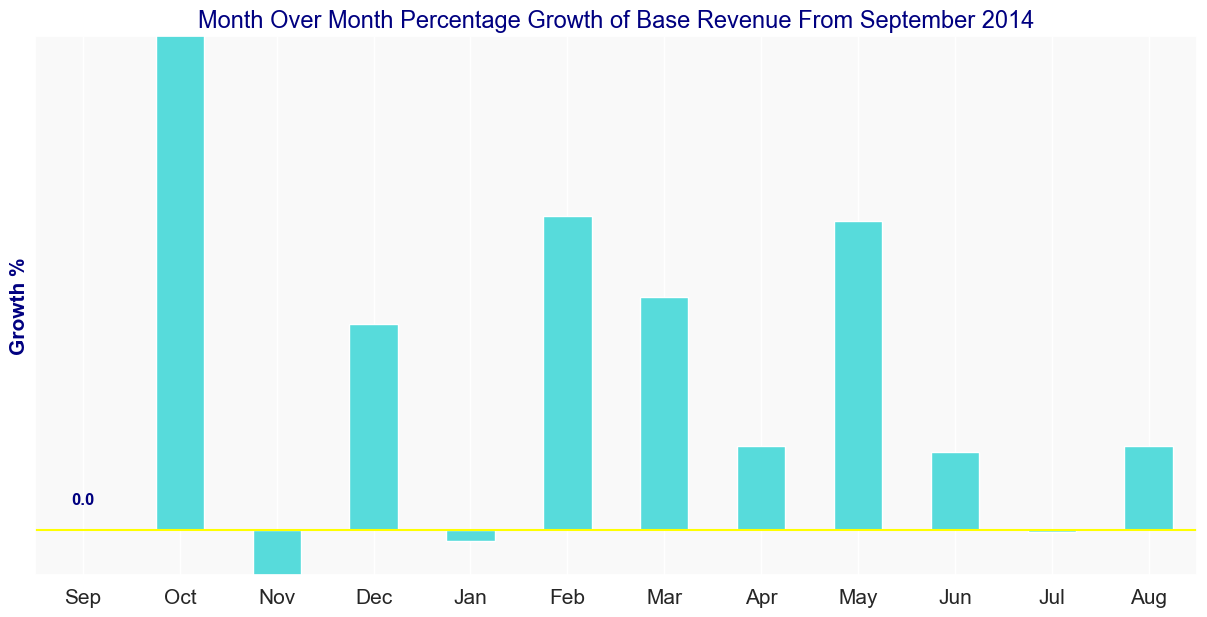

In [128]:
#Annotate Total Cummulative Growth for the Period

df_plt1 = pd.DataFrame(pd.Series(dict_growth), index = month_labels, columns = ['growth_pct'])

labels_list = df_plt1.growth_pct.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt1.plot(kind = 'bar', figsize = (15,7), fontsize = 14, rot = 0, legend=False)#df_plt2[1:] to exclude Sep
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.axhline(0, color='yellow')
plt.title('Month Over Month Percentage Growth of Base Revenue From September 2014', 
          fontsize = 17, color='navy')
plt.ylabel('Growth %', fontsize = 15, weight='bold', color='navy')
plt.ylim(-2, 22)
plt.tick_params(labelsize=15)

plt.show()

Cummulative % Growth Over Period: 100.72545020447807


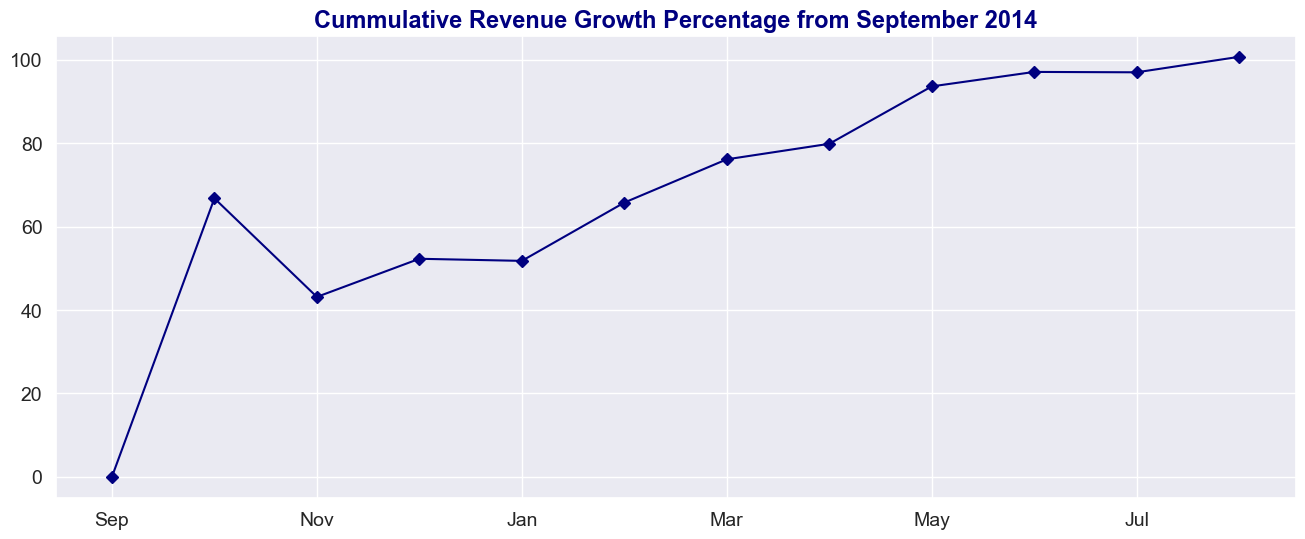

In [129]:
#Plot Cummulative Base Revenue Growth Over the Period
print('Cummulative % Growth Over Period:', df_plt1.growth_pct.sum())

df_plt1.cumsum().plot(color = 'navy', marker = 'D', legend = False, figsize=(16, 6))
plt.title('Cummulative Revenue Growth Percentage from September 2014', fontsize=17, weight='bold', color='navy')
plt.tick_params(labelsize=14)
plt.show()

In above two cells of code we get to know that revenue per month generally increases month by month in that period except the month of january and june, this may be happened because of 2 Federal holiday's in month of january and summer vacation started from july.
We get to know that revenue increased by ~84% in a period of one year.

## Which day of the week has the worst (slowest) traffic overall?

In [131]:
#Create dataframe with grouped data.
df_plt2 = df_uber.groupby('weekday')['trip_mph_avg'].median() #used median since distribution is skewed.

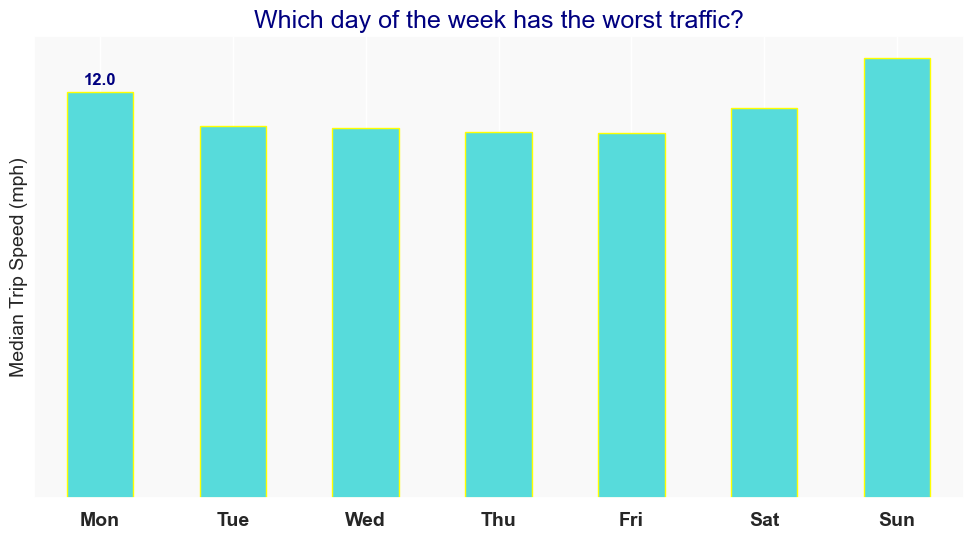

In [132]:
#Create plot. Does Saturday have better traffic flow than Monday?

fig = plt.figure()
labels_list = df_plt2.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt2.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
ax.set_xticklabels(weekday_labels, weight='bold')
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Median Trip Speed (mph)', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the worst traffic?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

## What is the median distance traveled per trip? Are there any insights we can learn from it?

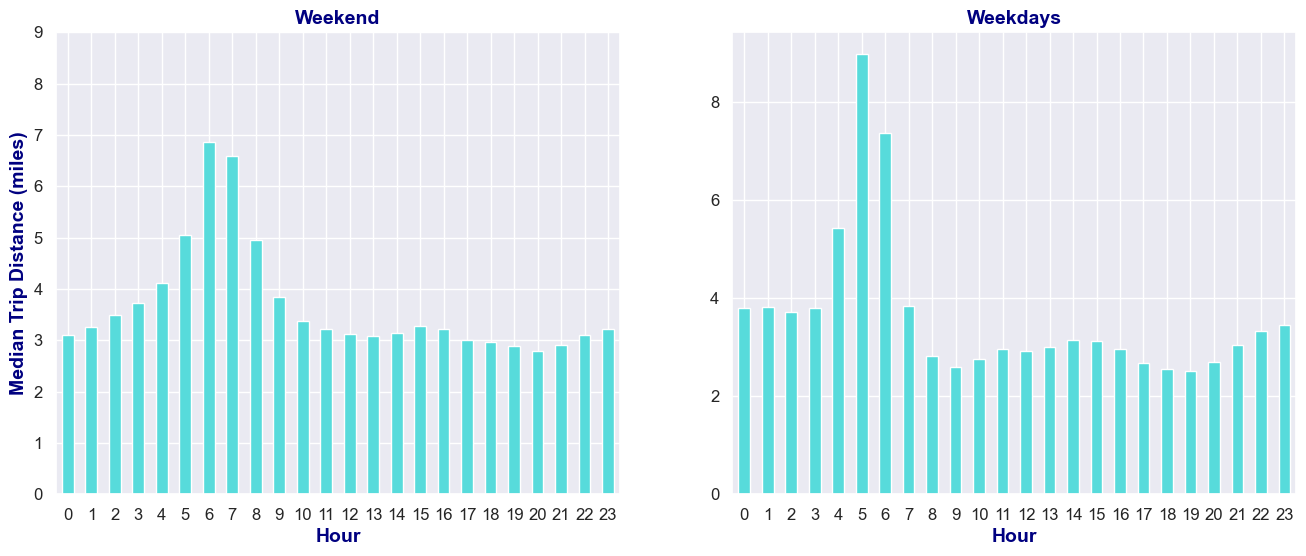

In [135]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
df_uber[(df_uber.weekday >= 5)].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0, fontsize=14)
plt.ylim(0, 9)
plt.tick_params(labelsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=14, weight='bold', color='navy')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend', fontsize=14, weight='bold', color='navy')

plt.subplot(1,2,2)
df_uber[df_uber.weekday < 5].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0)
plt.tick_params(labelsize=12)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekdays', fontsize=14, weight='bold', color='navy')

plt.show()

In [ ]:
Why is the median distance traveled around 5 AM much longer than at the other times?Could it be picking up riders that would otherwise use public transportation to the outer boroughs?
While the subway runs 24/7 in NYC, bus services don't. It's clear though that most customer are within Manhattan.

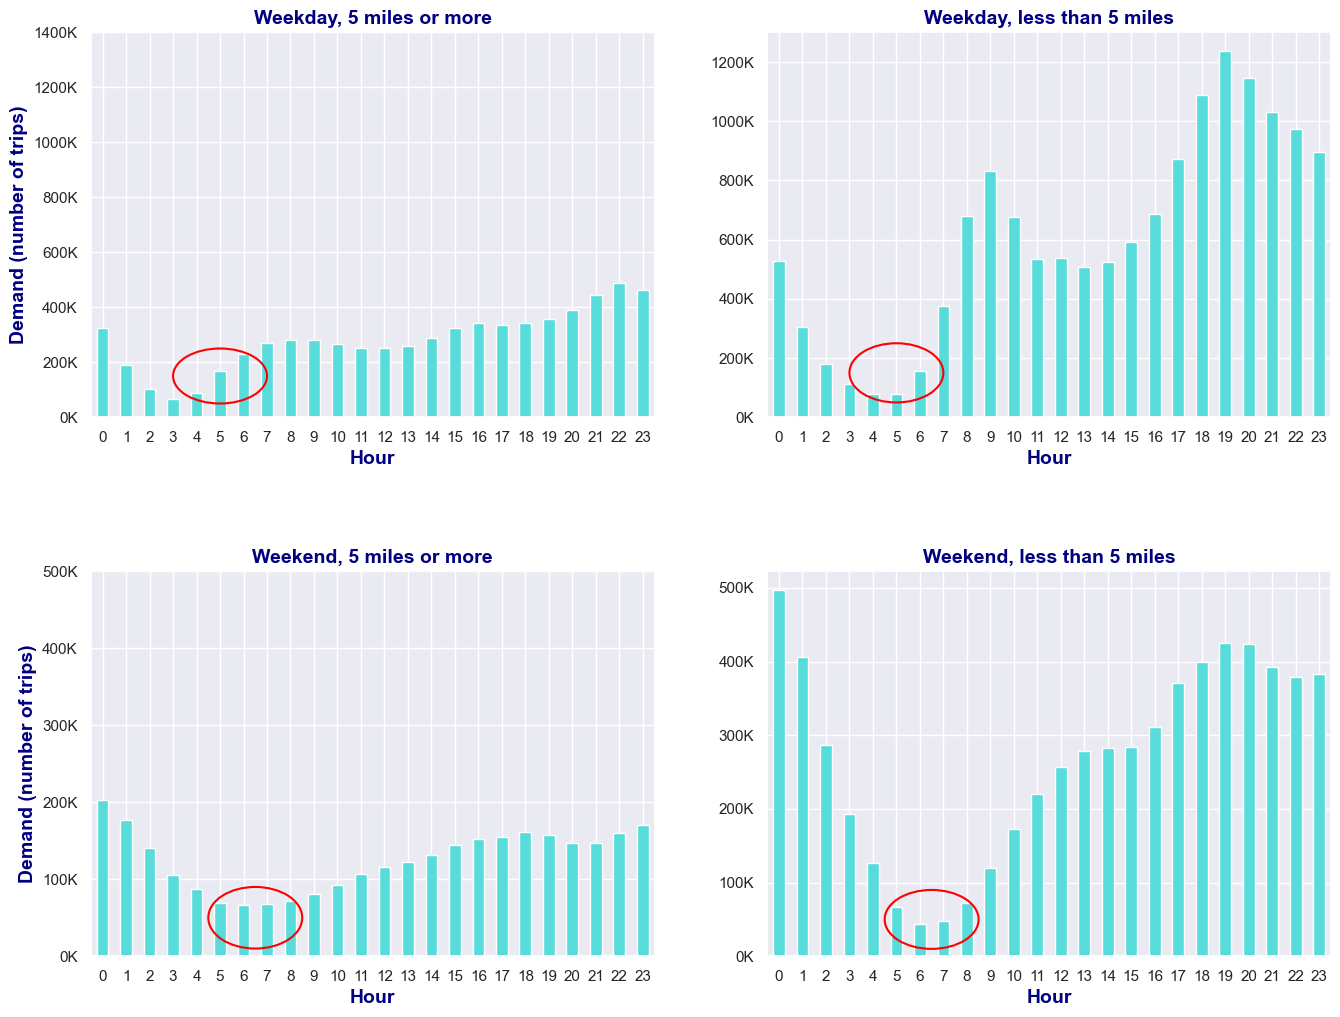

In [137]:
#Create plot similar to the above but with the count of trips per hour, comparing weekday vs weekend and 
#distances >=5 versus < 5 miles. Indeed, the plots show that there is a higher demand for trips that go beyond 
#miles (outside Manhattan) from 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends (Saturday and Sunday).

fig = plt.figure(figsize = (16,12))
formatter = FuncFormatter(thousands_format)


plt.subplot(2,2,1)
ax1 = df_uber[(df_uber.weekday < 5) & (df_uber.trip_distance >= 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax1.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax1.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 1400000)
plt.title('Weekday, 5 miles or more', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,2)
ax2 = df_uber[(df_uber.weekday < 5) & (df_uber.trip_distance < 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax2.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax2.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekday, less than 5 miles', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,3)
ax3 = df_uber[(df_uber.weekday >= 5) & (df_uber.trip_distance >= 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax3.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax3.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 500000)
plt.title('Weekend, 5 miles or more', fontsize=14, weight='bold', color='navy')

plt.subplot(2,2,4)
ax4 = df_uber[(df_uber.weekday >= 5) & (df_uber.trip_distance < 5)].\
groupby('hour')['trip_distance'].count().plot(kind='bar', rot = 0)
ax4.yaxis.set_major_formatter(formatter)
ellipse = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax4.add_patch(ellipse)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend, less than 5 miles', fontsize=14, weight='bold', color='navy')


fig.subplots_adjust(hspace=0.4)
plt.show()
#plot_url = py.plot_mpl(fig)

The red circles highlight the focus areas where the number of long trips is greater than the number of short trips, and this occurs both on weekdays and weekends, although at slightly different times: the demand is higher for longer trips from about 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends.

## What are the most popular pickup and drop-off taxi zones?

C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\3053647723.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\3053647723.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])


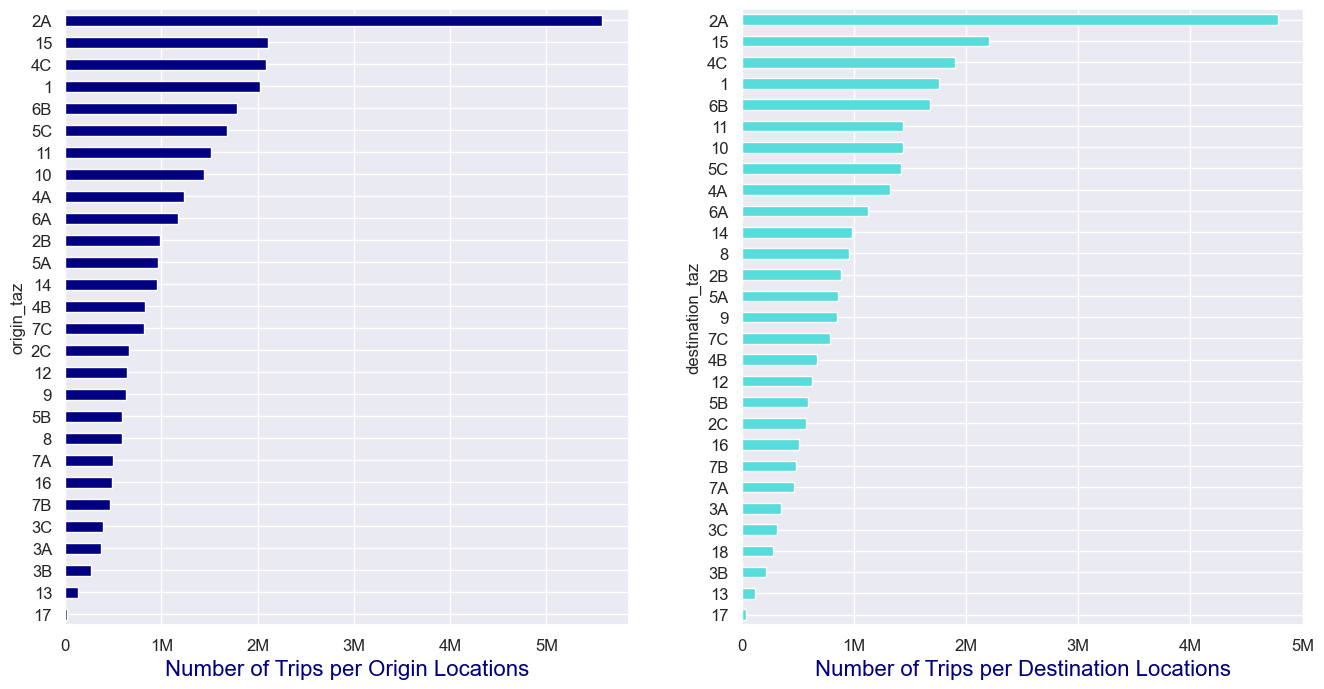

In [140]:
#CREATE INSTEAD SIDE-STACKED PLOT WITH TOP 10 PICKUP AND DROP-OFF LOCATIONS? OR TRY TOYPLOT WITH VALUE FOR EACH BAR.
fig = plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
ax1 = df_uber.origin_taz.value_counts(ascending = True).plot(kind = 'barh', color = 'navy')
ax1.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)
plt.xlabel('Number of Trips per Origin Locations', fontsize = 16, color='navy')

plt.subplot(1,2,2) #note: it won't account missing values (4% of data)
ax2 = df_uber.destination_taz.value_counts(ascending = True).plot(kind = 'barh')
ax2.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)
plt.xlabel('Number of Trips per Destination Locations', fontsize = 16, color='navy')

plt.show()
#plot_url = py.plot_mpl(fig)

In [154]:
#Percentage of trips represented by the top five origins/destinations:
print(df_uber.origin_taz.value_counts().head(5).sum()/float(len(df_uber))) #13,583,249
print(df_uber.destination_taz.value_counts().head(5).sum()/float(len(df_uber[df_uber.destination_taz.isnull() == False])))                                         

0.4392214989339947
0.41585139843012686


In [153]:
#Total pickups or drop-offs within any combination of the top 5 locations: 6231353 (20% of the total trips)
len(df_uber[(df_uber.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_uber.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])

6231770

In [152]:
#29% of all trips start or finish at 2A:
len(df_uber[(df_uber.origin_taz == '2A') | (df_uber.destination_taz == '2A')])/(1.0*len(df_uber)) #8979830

0.29038395138702916

The most popular pickup and drop-off locations are 2A. In fact, 29% of all Uber trips during the analyzed period have either started or ended in this zone.

## Visualizing the most popular pick up and drop off location pairs.

In [147]:
#Define data to plot:
df_plt3 = df_uber.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

In [148]:

df_plt3.shape

(28, 29)

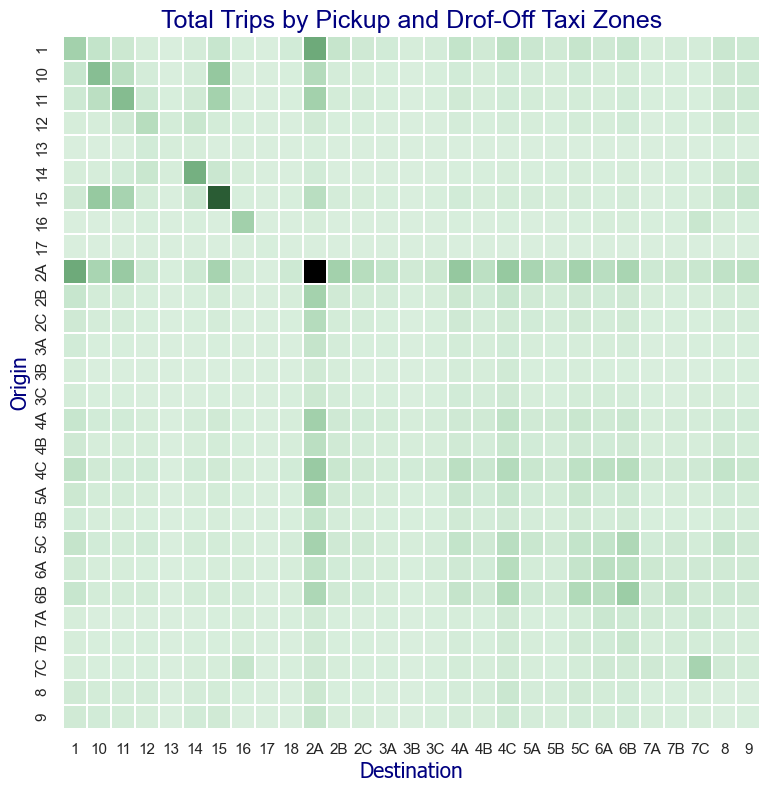

In [149]:
#Visualize the origin versus destination matrix via a heatmap:

fig = plt.figure(figsize=(9,9))

cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.9, as_cmap=True) #'YlOrRd' #ggplot:'viridis'

sns.heatmap(df_plt3, cmap=cmap, linewidths=0.1, cbar=False)

plt.title('Total Trips by Pickup and Drof-Off Taxi Zones', fontsize=18, color='navy')
plt.xlabel('Destination', fontsize=15, fontname='Tahoma', color='navy')
plt.ylabel('Origin', fontsize=15, fontname='Tahoma', color='navy')
plt.tick_params(labelsize=11)
plt.show()

In [151]:
len(df_viz[(df_uber.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_uber.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])
6231752

C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\3190474408.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_viz[(df_uber.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \


6231752

## What is the mean time and distance to destination from the most popular pick up location?

In [155]:
#Plot the mean travel time from the most popular origin, to all possible destinations.
df_plt4 = df_uber[df_uber.origin_taz == '2A'].groupby('destination_taz')['trip_distance'].mean().sort_values()
df_plt5 = df_uber[df_uber.origin_taz == '2A'].groupby('destination_taz')['duration_min'].mean().sort_values()

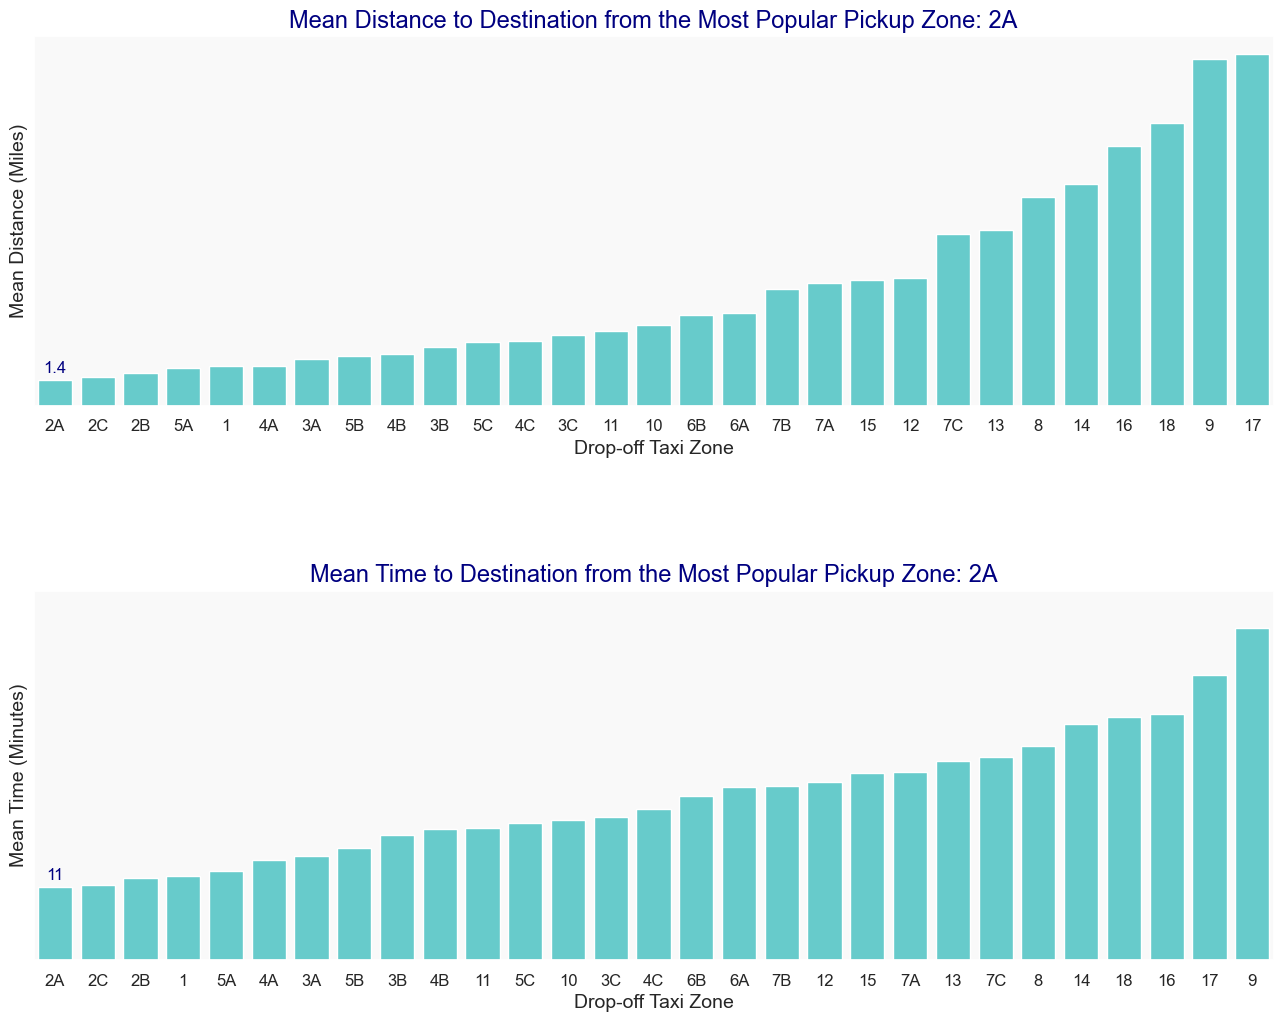

In [156]:
#Assuming 18 is EWR, and given the average driving distance from 2A, this pick up location is probably located in 
#Midtown, not in Lower Manhattan (Penn Station lat/long: 40.750568, -73.993519)
#Straight line distance: 11 miles, Driving distance: 15 miles Difference: 36%
#The mean time and distance to zone 18 adds further evidence that it's the EWR airport (from Midtown).
#Based on the distance from 2A, if the origin is Midtown, then 15 is in Upper Manhattan.

fig = plt.figure(figsize = (16,12))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'color': 'navy'}


plt.subplot(2,1,1)
ax1 = sns.barplot(x=df_plt4.index, y=df_plt4.values)
ax1.set_facecolor('#F9F9F9')
#ax1.set_yticks(range(0, 21, 2))
ax1.get_yaxis().set_ticks([])
labels_list = df_plt4.values.round(1)
annotate_labels(ax1, labels_list, **kwargs)
plt.title('Mean Distance to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Distance (Miles)', fontsize = 14)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


plt.subplot(2,1,2)
ax2 = sns.barplot(x=df_plt5.index, y=df_plt5.values)
ax2.set_facecolor('#F9F9F9')
#ax2.set_yticks(range(0, 51, 5))
ax2.get_yaxis().set_ticks([])
labels_list = df_plt5.apply(lambda x: '{:.0f}'.format(round(x))).values
annotate_labels(ax2, labels_list, **kwargs)
plt.title('Mean Time to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Time (Minutes)', fontsize = 14)
plt.ylim(0,55)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


fig.subplots_adjust(hspace=.5)
plt.show()
#plot_url = py.plot_mpl(fig)

The charts above show the mean distance and time to destination for a trip originating at 2A.

The data has 28 unique origin codes and 29 unique destination codes. Assuming that code 18, the extra destination code, represents the Newark Airport (EWR), a relevant destination outside of New York City, then we can infer that 2A is in Midtown, based on the mean time and distance to arrive at location 18.

Given the concentrated demand within Manhattan, about 68% of all Uber trips have a driven distance of 5 miles or less.

# Visualization of Variable Distributions and Bivariate Relationships.
Distribution of trip distance

In [159]:
df_uber.trip_distance.max(), df_uber.trip_distance.max()

(2593.08, 2593.08)

In [160]:
freq, bins_dist = np.histogram(df_uber.trip_distance, bins=10, range=(0, 25))
freq, bins_dist

(array([12709831,  8364583,  3567026,  2035414,  1296944,   672728,
          706032,   747780,   299956,   132578]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]))

In [161]:
#69% of all trips had distance < 5 miles
for val in freq:
    print(float(val)/sum(freq))

0.41626713006231447
0.27395336409886367
0.11682576077350339
0.06666303779087666
0.0424769736695585
0.02203290931819319
0.02312366815673285
0.0244909813921206
0.009824034895898427
0.004342139841938223


In [162]:
df_uber.trip_distance.median(), df_uber.trip_distance.mean()

(3.09, np.float64(5.19993524078056))

In [163]:
print(len(df_uber[df_uber.trip_distance <= 5])/(1.0 *len(df_uber))) #68% of trips are 5 miles or less
print(len(df_uber[df_uber.trip_distance <= 2])/(1.0 *len(df_uber))) #32% of trips are 2 miles or less

0.6821325331023629
0.3192312500351649


In [164]:
#Vey long distance trips (>= 300 miles):
df_uber[df_uber.trip_distance >= 300].head(10) #45 total

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
943214,19594602,10,15,371.5500,2014-09-16,2014,9,16,10,1,474.2833,47.0035,818.7617
3620586,5138875,14,NaN,357.2700,2014-11-04,2014,11,4,23,1,309.5167,69.2570,736.1033
10581718,10072444,16,NaN,330.9000,2015-02-04,2015,2,4,18,2,648.5000,30.6153,808.6000
11224977,17353914,15,15,378.0100,2015-02-25,2015,2,25,15,2,600.7667,37.7528,874.3358
11684172,23119455,14,14,350.1500,2015-02-03,2015,2,3,18,1,559.3500,37.5597,811.0850
13829799,16426984,15,NaN,568.5700,2015-03-27,2015,3,27,19,4,652.3167,52.2970,1225.8583
16530542,15478567,7A,17,315.5700,2015-04-09,2015,4,9,1,3,248.0667,76.3271,641.6208
18643154,6860856,5C,16,308.4200,2015-05-31,2015,5,31,5,6,304.1833,60.8357,648.7492
18854980,9245564,15,15,302.7900,2015-05-10,2015,5,10,22,6,441.6667,41.1337,687.0158
18949729,10208984,4A,7C,335.3000,2015-05-09,2015,5,9,16,5,813.6667,24.7251,874.1083


# Distribution of trip duration (in minutes)

In [166]:
#Median trip duration is ~ 17 minutes
df_uber.duration_min.describe()

count   30925738.0000
mean          22.3337
std         3712.2298
min            0.0000
25%           10.8500
50%           17.2333
75%           26.6833
max     10321959.0500
Name: duration_min, dtype: float64

In [167]:
freq, bins_dur = np.histogram(df_uber.duration_min, bins=10, range=(0, 50))
freq, bins_dur

(array([1235201, 5391527, 6312324, 5266965, 3929223, 2777187, 1878407,
        1256167,  852543,  589921]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

# Plot of the histograms for trip distance and duration

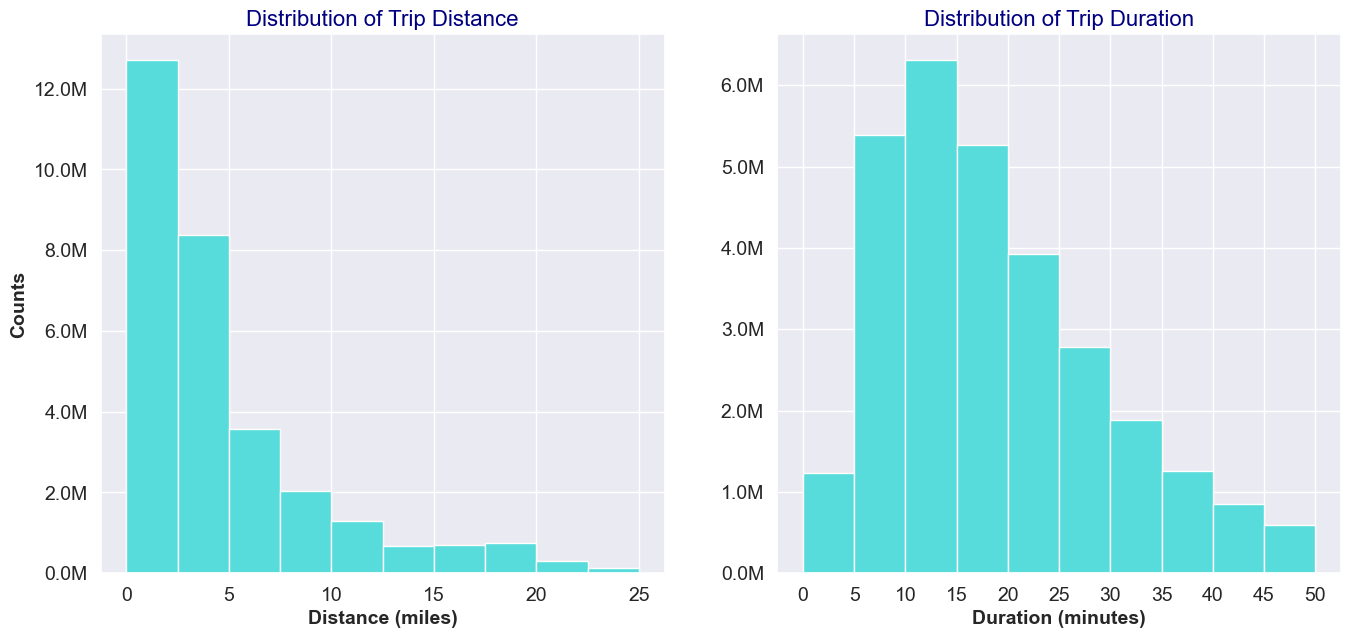

In [168]:
#Here we plot the distribution of trip duration next to the histogram of trip distance for comparison.
fig = plt.figure(figsize=(16, 7))

formatter = FuncFormatter(millions_format)

plt.subplot(1,2,1)
ax1 = df_uber.trip_distance.dropna().hist(bins=bins_dist)
ax1.yaxis.set_major_formatter(formatter)

plt.xlabel('Distance (miles)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Distance', color='navy', fontsize=16)


plt.subplot(1,2,2)
ax2 = df_uber.duration_min.hist(bins=bins_dur)
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xticks(bins_dur) #bins are in 5 minutes intervals.

plt.xlabel('Duration (minutes)', fontsize=14, weight='bold')
plt.ylabel('')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Duration', color='navy', fontsize=16)

plt.show()

# Trip Distance versus Trip Duration

In [172]:
#Create data to plot with average distance and duration grouped by origin-destination location pairs:
df_plt6 = df_uber.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'duration_min']].mean()

In [174]:
df_plt6.values

array([[ 1.42185534, 10.56551251],
       [ 3.65079126, 17.97757849],
       [ 5.0936793 , 22.48992547],
       ...,
       [19.8491493 , 44.58753093],
       [12.19842835, 29.74001046],
       [ 2.52619245, 10.10206914]], shape=(812, 2))

In [175]:
df_plt6.shape #distance, duration (x, y): Fit function to replace 7 incorrect duration entries with estimate. 

(812, 2)

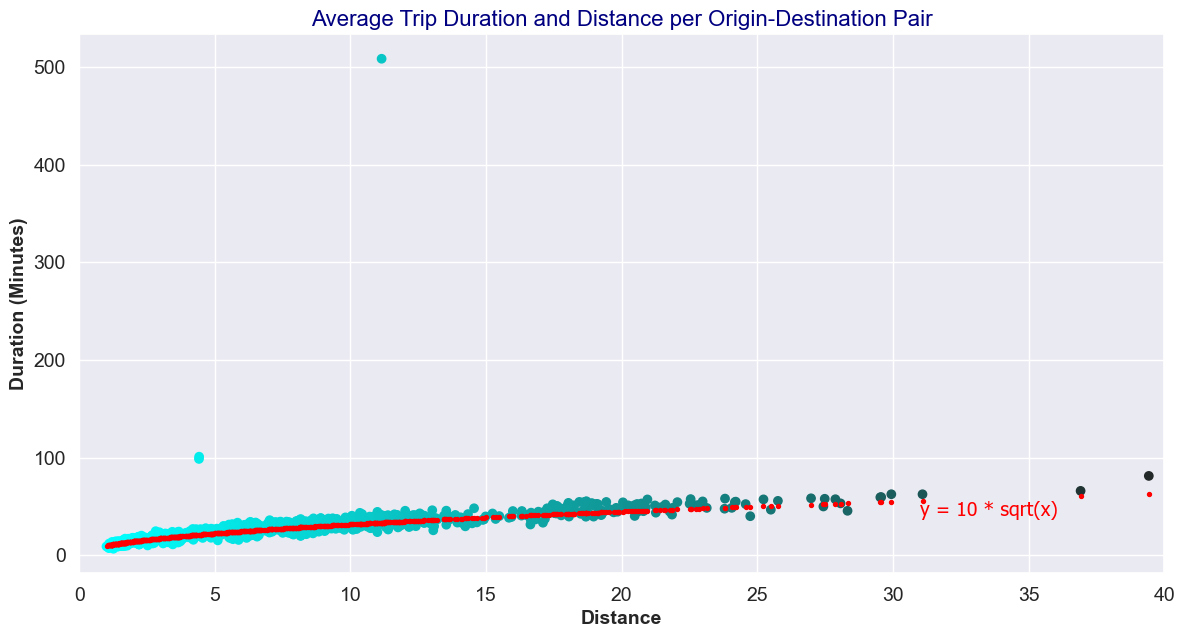

In [178]:
#Create plot.
distance = df_plt6.values[:,:1]
duration = df_plt6.values[:,1:]
duration_hat = pd.Series(distance.reshape(812,)).apply(lambda x: 10*np.sqrt(x))

plt.figure(figsize = (14,7))
cmap = sns.dark_palette('cyan', 3, reverse = True, as_cmap=True)

plt.scatter(distance, duration, c=distance, cmap= cmap) # it looks like a 10*sqrt(x) power distribution
plt.scatter(distance, duration_hat, color='red', s=8)

font = {'color': 'red', 'size': 14, 'family': 'Tahoma'}
plt.text(31, 40, 'y = 10 * sqrt(x)', fontdict = font) 
plt.xlim(0, 40)
plt.xlabel('Distance', fontsize = 14, weight='bold')
plt.ylabel('Duration (Minutes)', fontsize = 14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Average Trip Duration and Distance per Origin-Destination Pair', fontsize = 16, color='navy')


plt.show()

The relation between a trip’s duration and distance is not entirely linear. Rather, it approximates to a power function because the shorter trips, occurring mostly within busy areas of traffic, tend to result in lower average trip speed.

In [179]:
df_plt6[df_plt6.trip_distance > 25] #origin and destination pairs whose distance between them is greater than 25 miles

trip_distance  duration_min
origin_taz destination_taz                             
13         18                     28.0717       53.1685
14         17                     27.8808       57.4252
           18                     29.9431       62.5171
16         17                     31.0922       62.5046
           18                     28.3292       45.5679
17         14                     27.4876       57.8793
           16                     39.4353       81.2769
           7C                     25.2298       57.2576
           9                      25.5005       46.6947
7A         17                     29.5695       59.6055
7C         17                     26.9832       58.3610
8          17                     25.7619       55.7408
           18                     29.5376       59.4060
9          17                     27.4381       49.9894
           18                     36.9205       65.9577

# Distribution of the average speed per trip

In [181]:
#Note: this uses processed data (24904 (0.08%) entries with null or zero in duration resulted in null value for speed)
df_uber.trip_mph_avg.describe()

count   30900872.0000
mean          13.5073
std           11.7568
min            0.0000
25%            8.4100
50%           11.4489
75%           16.2668
max        22548.0000
Name: trip_mph_avg, dtype: float64

In [182]:
freq, bins = np.histogram(df_uber.trip_mph_avg, bins=10, range=(0, 50))
freq, bins

(array([ 1313561, 10564992,  9862420,  4248624,  2152852,  1282012,
          767843,   434359,   196184,    61866]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

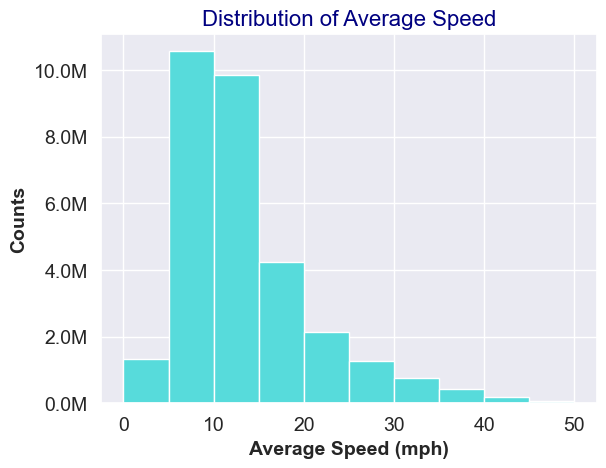

In [183]:
fig, ax = plt.subplots(1,1)

formatter = FuncFormatter(millions_format)

ax.hist(df_uber.trip_mph_avg.dropna(), bins)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Average Speed (mph)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Average Speed', color='navy', fontsize=16)
plt.show()

More than 80% of rides have the avg. speed from 5 km per hour(i.e. greater than avg walking speed) to 20 km per hour .

In [185]:
#Median trip average speed during weekdays:
df_plt7 = df_uber[df_uber.weekday < 5].groupby('hour')['trip_mph_avg'].median()
df_plt7.head()

hour
0   14.3014
1   15.3747
2   16.1274
3   16.6126
4   19.5019
Name: trip_mph_avg, dtype: float64

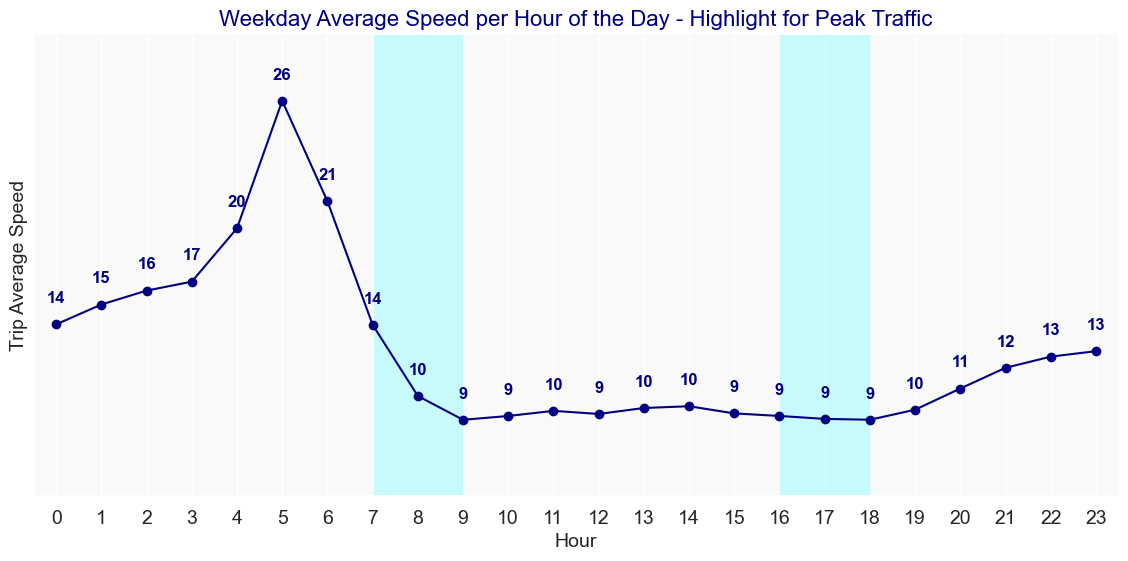

In [186]:
#Plot Peak Hour Median Trip Average Speed During Weekdays:

plt.figure(figsize =(14, 6))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'top', 'color': 'navy', 'weight': 'bold'}

#weekdays only: rush hour traffic 7-9 + 16-18
ax = df_plt7.plot(marker = 'o', color = 'navy')

for x, y in zip(df_plt7.index, df_plt7.values):
    ax.annotate('{:.0f}'.format(y), xy=(x, y), xytext= (0, 24), textcoords='offset points', **kwargs)

ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([]) #hide tick labels on y-axis
plt.fill([7,9,9,7], [0,0,30,30], 'cyan', alpha=0.2)
plt.fill([16,18,18,16], [0,0,30,30], 'cyan', alpha=0.2)
plt.xticks(range(24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Trip Average Speed', fontsize=14)
plt.ylim(5, 30)
plt.xlim(-0.5, 23.5)
plt.tick_params(labelsize=14)
plt.title('Weekday Average Speed per Hour of the Day - Highlight for Peak Traffic', fontsize = 16, color='navy')
plt.show()

In [187]:
def is_peak_hour(x):
    """ 
    Function that takes an array(x) with two integers representing 
    hour of the day and weekday, respectively, and
    returns 1 if it's peak hour as defined, 0 otherwise.
    """
    return 1 if x[0] in (7,8,9,16,17,18) and x[1] < 5 else 0 #total peak hour periods = 6h

In [191]:
df_uber['peak_hour'] = pd.Series(map(lambda x: is_peak_hour(x), df_viz.loc[:, ['hour', 'weekday']].values))

In [192]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue,peak_hour
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017,0.0000
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767,0.0000
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700,0.0000
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000,0.0000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917,0.0000


C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\4194551084.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(month_labels)
C:\Users\Vikram\AppData\Local\Temp\ipykernel_22072\4194551084.py:12: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(handles, labels=['Peak', 'Off Peak'], loc='best', fontsize=13)


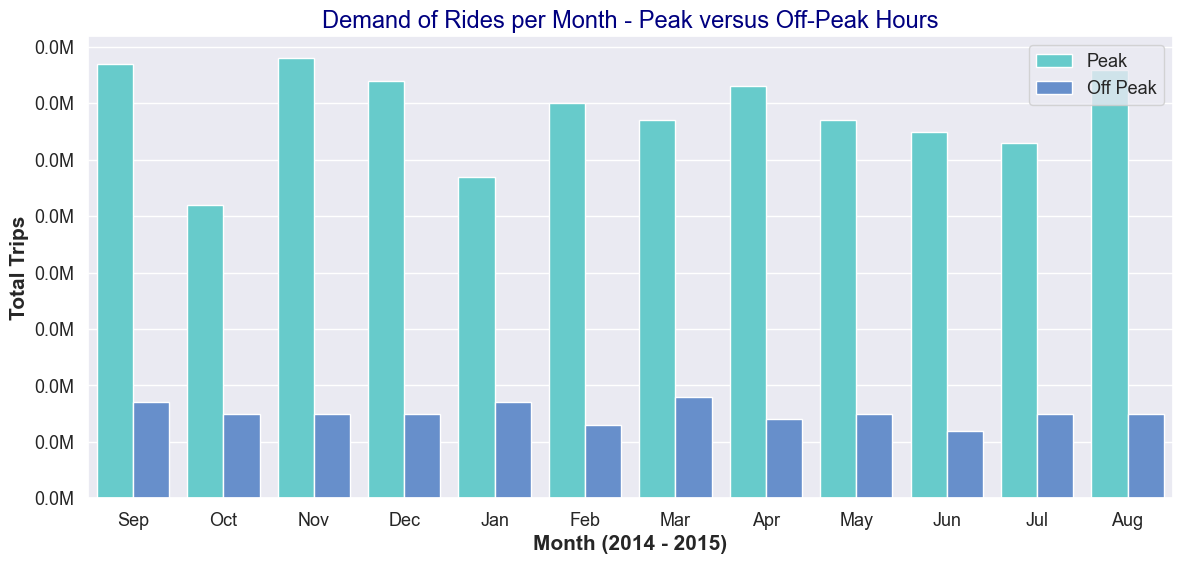

In [195]:
#Plot the total number of trips per month during peak hours and off-peak hours.
#Count for peak hours must represent more than 25% (6h) of the total rides to be more significant than non-peak hours.
plt.figure(figsize = (14, 6))
formatter = FuncFormatter(millions_format)

#to add labels and operate on data, use pivot instead of countplot directly with hue.
ax = sns.countplot(x = df_viz['month'], hue = df_viz['peak_hour'])
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

handles, labels = ax.get_legend_handles_labels() #will cause the warning msg that can be ignored 
plt.legend(handles, labels=['Peak', 'Off Peak'], loc='best', fontsize=13)
plt.tick_params(labelsize=13)
plt.xlabel('Month (2014 - 2015)', fontsize = 15, weight='bold')
plt.ylabel('Total Trips', fontsize = 15, weight='bold')
plt.title('Demand of Rides per Month - Peak versus Off-Peak Hours', fontsize = 17, color='navy')
plt.show()

# Data Modelling